In [147]:
import xmltodict
from urllib.request import urlopen
import xml.etree.ElementTree as ET
import pandas as pd

from dateutil.parser import parse

import matplotlib.pyplot as plt
from IPython.display import display 

plt.style.use('seaborn-paper')
%matplotlib inline

# Hansard - OralQuestionPeriod

In [150]:

def xml2df(xml_data):
#     print(xml_data)
    root = ET.XML(xml_data) # element tree

    all_records = [] #This is our record list which we will convert into a dataframe
    
    orderOfBusinessList = root.find('HansardBody').iter('OrderOfBusiness')
    
    for orderOfBusiness in orderOfBusinessList:
        
        orderOfBusinessRubric = orderOfBusiness.attrib['Rubric']
#         print('orderOfBusinessRubric', orderOfBusinessRubric)
        if (orderOfBusinessRubric == 'OralQuestionPeriod'):
        
            orderOfBusinessId =  orderOfBusiness.attrib['id']            
            orderOfBusinessCatchLine = orderOfBusiness.find('CatchLine').text
        
            for subjectOfBusiness in orderOfBusiness.findall('SubjectOfBusiness'):

                subjectOfBusinessContent = subjectOfBusiness.find('SubjectOfBusinessContent')
                for intervention in subjectOfBusinessContent.iter('Intervention'):
                    
                    record = {} #Place holder for our record
                    record['orderOfBusinessId'] = orderOfBusinessId
                    record['orderOfBusinessRubric'] = orderOfBusinessRubric
                    record['orderOfBusinessCatchLine'] = orderOfBusinessCatchLine
                        
                    try:
                        record['subjectOfBusinessId'] = subjectOfBusiness.attrib['id']
                    except Exception:
                        continue    
                        
                    
                    if subjectOfBusiness.find('SubjectOfBusinessTitle') is not None:
                        record['SubjectOfBusinessTitle'] = subjectOfBusiness.find('SubjectOfBusinessTitle').text.strip()
                    else:
                        record['SubjectOfBusinessTitle'] = 'generic'
                        

                    if subjectOfBusiness.find('FloorLanguage') is not None:
                        record['FloorLanguage'] = subjectOfBusiness.find('FloorLanguage').attrib['language']
                    else:
                        record['FloorLanguage'] = 'EN'

                    record['personSpeaking'] = intervention.findall('PersonSpeaking/Affiliation')[0].text
                    record['personId'] =intervention.findall('PersonSpeaking/Affiliation')[0].attrib['DbId']
                    content = []
                    for paraText in intervention.iter('ParaText'):
                        if paraText.text is not None:
                            content.append(paraText.text)

                    record['content'] = ' \lineBreak '.join(content)
                    all_records.append(record) #Append this record to all_records. 
                    
    
    df = pd.DataFrame(all_records)
    return df #return records as DataFrame

# Id	paragText	speakerId	timestamp




In [162]:
# link = 'http://www.ourcommons.ca/Content/House/421/Debates/{session}/HAN{session}-E.XML'
link = 'http://www.ourcommons.ca/Content/House/412/Debates/{session}/HAN{session}-E.XML'


link_list = []
# for parliamentSession in ['411', '421']
session = 236
# session = 264

for i in range (1, session):
    temp = link.replace('{session}', '{:03}'.format(i))
    link_list.append(temp)

    
df_list = []

for link in link_list:
    print(link)
    urlContent = urlopen(link)
    xml = urlContent.read()
    df = xml2df(xml)
    df_list.append(df)

df_hansard = pd.concat(df_list)
df_hansard.reset_index(inplace=True)

df_hansard.to_csv('data/hansard41_2.csv')
df_hansard.tail()

http://www.ourcommons.ca/Content/House/411/Debates/001/HAN001-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/002/HAN002-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/003/HAN003-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/004/HAN004-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/005/HAN005-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/006/HAN006-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/007/HAN007-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/008/HAN008-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/009/HAN009-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/010/HAN010-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/011/HAN011-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/012/HAN012-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/013/HAN013-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/014/HAN014-E.XML
http://www.ourcommons.ca/Content/House/411/Debat

http://www.ourcommons.ca/Content/House/411/Debates/122/HAN122-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/123/HAN123-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/124/HAN124-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/125/HAN125-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/126/HAN126-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/127/HAN127-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/128/HAN128-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/129/HAN129-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/130/HAN130-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/131/HAN131-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/132/HAN132-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/133/HAN133-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/134/HAN134-E.XML
http://www.ourcommons.ca/Content/House/411/Debates/135/HAN135-E.XML
http://www.ourcommons.ca/Content/House/411/Debat

,index,FloorLanguage,SubjectOfBusinessTitle,content,orderOfBusinessCatchLine,orderOfBusinessId,orderOfBusinessRubric,personId,personSpeaking,subjectOfBusinessId
21383,96,EN,Points of Order,"Mr. Speaker, I will speak with the minister in...",Oral Questions,7967049,OralQuestionPeriod,170693,Hon. Peter Van Loan,7967384
21384,97,EN,Points of Order,I thank the hon. government House leader for t...,Oral Questions,7967049,OralQuestionPeriod,170958,The Speaker,7967384
21385,98,FR,Privilege,"Yesterday, the members for Ottawa—Vanier and T...",Oral Questions,7967049,OralQuestionPeriod,170958,The Speaker,7967591
21386,99,EN,generic,"Mr. Speaker, it is with great honour to rise t...",Oral Questions,7967049,OralQuestionPeriod,170432,"Mr. LaVar Payne (Medicine Hat, CPC)",7967630
21387,100,EN,generic,I thank the hon. member for,Oral Questions,7967049,OralQuestionPeriod,170958,The Speaker,7967630


Ethics                                     3952
National Defence                           2506
Taxation                                   2266
The Environment                            1843
Foreign Affairs                            1432
Health                                     1096
Employment Insurance                       1086
Natural Resources                          1036
International Trade                        1031
Public Safety                               971
Democratic Reform                           914
Justice                                     885
Indigenous Affairs                          870
The Economy                                 861
Infrastructure                              854
Aboriginal Affairs                          748
Points of Order                             722
Employment                                  721
Pensions                                    673
Foreign Investment                          665
Government Appointments                 

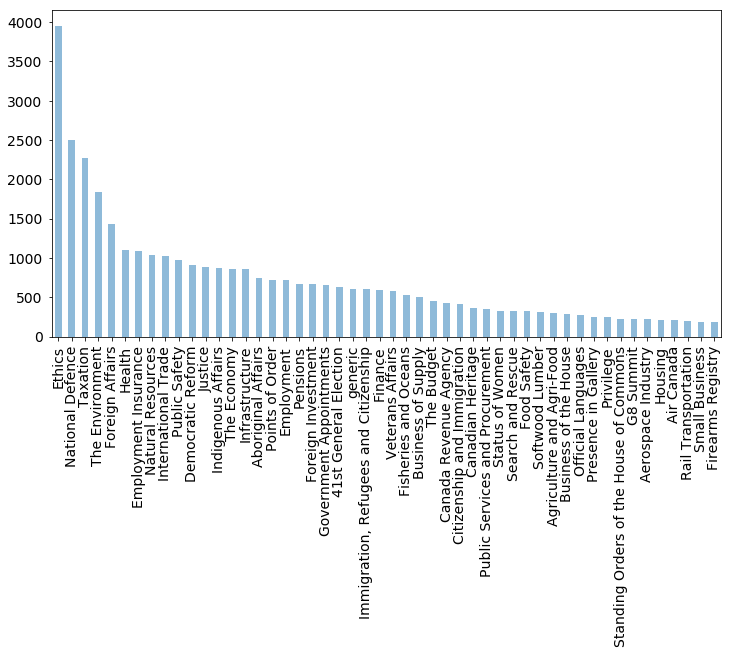

In [178]:
# df_hansard.info()
# print(len(df_hansard))
# df_hansard.tail()
# df_hansard.iloc[24318]

df_41 = pd.read_csv('data/hansard41.csv')
df_42 = pd.read_csv('data/hansard.csv')

df_hansard = pd.concat([df_41, df_42])
df_hansard.reset_index(inplace=True)

df_hansard.to_csv('data/hansard_full.csv')

# for idx, row in df_hansard.iterrows():
#     print (idx, row['content'])
#     break

# print(df_hansard['SubjectOfBusinessTitle'].unique())
print(df_hansard['SubjectOfBusinessTitle'].value_counts()[:50])

df_hansard['SubjectOfBusinessTitle'].value_counts()[:50].plot(kind='bar', alpha=.5, figsize=(12,6), fontsize=14)

# df_hansard.tail()

In [2]:
# https://www.ourcommons.ca/en/open-data#ChamberDebates
link =  'http://www.ourcommons.ca/Content/House/{ParliamentSession}/Debates/{SittingNumber}/HAN{SittingNumber}-E.XML'

# https://www.ourcommons.ca/Content/House/421/Debates/251/HAN251-E.XML
    
link = link.replace('{ParliamentSession}', '421')
link = link.replace('{SittingNumber}', '251')
link = link.replace('{SittingNumber}', '251')

print(link)


def xml2df(xml_data):
#     print(xml_data)
    root = ET.XML(xml_data) # element tree

    all_records = [] #This is our record list which we will convert into a dataframe
    
    orderOfBusinessList = root.find('HansardBody').iter('OrderOfBusiness')
    
    
    for orderOfBusiness in orderOfBusinessList:
        
#         print(orderOfBusiness.find('CatchLine'))
        orderOfBusinessId =  orderOfBusiness.attrib['id']
        orderOfBusinessRubric = orderOfBusiness.attrib['Rubric']
        orderOfBusinessCatchLine = orderOfBusiness.find('CatchLine').text
#         orderOfBusinessFloorLanguage = orderOfBusiness.find('SubjectOfBusiness')
        
#         record['timestamp'] = parse( publicationItem.attrib['Date'])
#         record['speakerId'] = publicationItem.find('Person').attrib['Id']
        paragraphs = []
        for subjectOfBusiness in orderOfBusiness.findall('SubjectOfBusiness'):
            record = {} #Place holder for our record
#             print(subjectOfBusiness.attrib)
            try:
                record['subjectOfBusinessId'] = subjectOfBusiness.attrib['id']
            except Exception:
                continue
                
            record['orderOfBusinessId'] = orderOfBusinessId
            record['orderOfBusinessRubric'] = orderOfBusinessRubric
            record['orderOfBusinessCatchLine'] = orderOfBusinessCatchLine
            
            if subjectOfBusiness.find('SubjectOfBusinessTitle') is not None:
                record['SubjectOfBusinessTitle'] = subjectOfBusiness.find('SubjectOfBusinessTitle').text
            else:
                record['SubjectOfBusinessTitle'] = 'generic'
            
            if subjectOfBusiness.find('FloorLanguage') is not None:
                record['FloorLanguage'] = subjectOfBusiness.find('FloorLanguage').attrib['language']
            else:
                record['FloorLanguage'] = 'EN'
               
#           print(subjectOfBusiness.findall("Intervention/PersonSpeaking/Affiliation"))
            # SpeakerId
#             if subjectOfBusiness.findall("./Intervention/PersonSpeaking/Affiliation") is not None:
#                 record['speakerId'] = subjectOfBusiness.findall("./Intervention/PersonSpeaking/Affiliation")[0].attrib['DbId']
#             else:
#                 record['speakerId'] = '1' # generic
                
                
                
            subjectOfBusinessContent = subjectOfBusiness.find('SubjectOfBusinessContent')
            
#             print(subjectOfBusinessContent.iter('ParaText'))
            content = []
            
            for paraText in subjectOfBusinessContent.iter('ParaText'):
                content.append(paraText.text)
                
            record['content'] = content
            
            all_records.append(record) #Append this record to all_records. 
            
#         record['paragText'] = paragraphs        
#         break
    
    df = pd.DataFrame(all_records)
    df.set_index(df['subjectOfBusinessId'])
    return df #return records as DataFrame

# Id	paragText	speakerId	timestamp

urlContent = urlopen(link)
xml = urlContent.read()
df = xml2df(xml)

# df['content'][2]

df.head()
# df.tail()
# df.info()





http://www.ourcommons.ca/Content/House/421/Debates/251/HAN251-E.XML


,FloorLanguage,SubjectOfBusinessTitle,content,orderOfBusinessCatchLine,orderOfBusinessId,orderOfBusinessRubric,subjectOfBusinessId
0,FR,Holiday Greetings,"[Mr. Speaker, all the snow we just got is a su...",Statements by Members,9895532,StatementsByMembers,9895535
1,EN,Beaches—East York,"[Mr. Speaker, the holidays are a time to spend...",Statements by Members,9895532,StatementsByMembers,9895539
2,EN,Christmas,"[Mr. Speaker, I have a little Christmas song t...",Statements by Members,9895532,StatementsByMembers,9895542
3,EN,Aga Khan,"[Mr. Speaker, December 13 marks the 81st birth...",Statements by Members,9895532,StatementsByMembers,9895545
4,EN,Hanukkah,"[Mr. Speaker, I would like to join with my wif...",Statements by Members,9895532,StatementsByMembers,9895548


In [13]:
# for row in df['content'].values:
#     print(row)

# df

In [14]:

link = 'http://www.ourcommons.ca/Parliamentarians/en/PublicationSearch?View=D&Item=&ParlSes=42-1&oob=&Topic=&Per=&Prov=&Cauc=&Text=&RPP=15&order=&targetLang=&SBS=0&MRR=150000&PubType=37&xml=1'
#        'http://www.ourcommons.ca/Parliamentarians/en/PublicationSearch?View=L&Item=&ParlSes=42-1&Topic=38047&com=&Per=&Prov=&Cauc=&PartType=&Text=&RPP=15&order=&targetLang=&SBS=0&MRR=2000000&PubType=40017&xml=1'
urlContent = urlopen(link)
xml = urlContent.read()
print(xml)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [12]:
# print(len(doc['Results']))

# print(doc['Results']['Publications']['Publication'][0]['PublicationItems']['PublicationItem'][0]
#       ['XmlContent']['Intervention']['Content']['ParaText'][1])



# <PublicationItem Id="9326459" EventId="9885804" 
# VideoURL="" Sequence="5" Page="16240" PdfPage="4" 
# TypeId="38" Date="2017-12-11" Hour="11" Minute="12" Second="20" 
# FacebookLink="?PubType=37&Item=9326459" TwitterLink="">
from datetime import datetime




def xml2df(xml_data):
#     print(xml_data)
    root = ET.XML(xml_data) # element tree

    all_records = [] #This is our record list which we will convert into a dataframe
    
    for publicationItem in root.iter('PublicationItem'):
        record = {} #Place holder for our record
        record['Id'] =  publicationItem.attrib['Id']
        record['timestamp'] = parse( publicationItem.attrib['Date'])
        record['speakerId'] = publicationItem.find('Person').attrib['Id']
        paragraphs = []
        for paratext in publicationItem.find('XmlContent').iter('ParaText'):
            paragraphs.append(paratext.text)
            
        record['paragText'] = paragraphs

        
    
        all_records.append(record) #Append this record to all_records. 
#         break
    
    df = pd.DataFrame(all_records)
    df.set_index(df['Id'])
    return df #return records as DataFrame

# print(urlContent.read())
df = xml2df(xml)

df.to_csv('results.csv' , sep='\t', encoding='utf-8')

# df
# df.describe()


# for item in doc['Results']['Publications']['Publication'][0]
# ['PublicationItems']['PublicationItem']:
# #     print(item['XmlContent']['Intervention']['Content']['ParaText'])
# #     for key in item.keys():
# #         print(key, item[key])
        

#     break
    
    


,Id,paragText,speakerId,timestamp
0,9658380,"[Mr. Speaker, I am pleased to once again speak...",25522,2018-02-12
1,9658081,"[Madam Speaker, I am very pleased to have the ...",59293,2018-02-12
2,9658389,"[Madam Speaker, it is a pleasure to rise and j...",72029,2018-02-12
3,9658516,"[Madam Speaker, it is an honour to stand here ...",89027,2018-02-12
4,9658613,[The question is on the motion. Is it the plea...,31289,2018-02-12
5,9658518,[The House will now suspend until noon.],31289,2018-02-12
6,9661757,[None],31289,2018-02-12
7,9659300,"[ moved: , None, She said: Madam Speaker, I wi...",89198,2018-02-12
8,9659382,"[Questions and comments, the hon. parliamentar...",31289,2018-02-12
9,9659383,"[Madam Speaker, I am a member of Parliament fr...",30552,2018-02-12
